Introducing sequential data
    
    - RNNs for modeling sequences
    
    - Long Short-Term Memory (LSTM)
    
    - Truncated Backpropagation Through Time (T-BPTT)
    
    - Implementing a multilayer RNN for sequence modeling in TensorFlow
    
    - Project one – RNN sentiment analysis of the IMDb movie review dataset
    
    - Project two – RNN character-level language modeling with LSTM cells, using  text data from Shakespeare's Hamlet
    
    - Using gradient clipping to avoid exploding gradients

Representing sequences

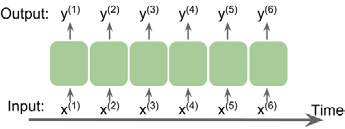

The different categories of sequence
modeling

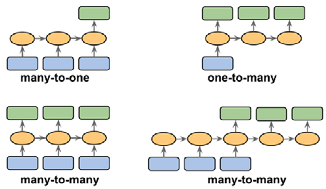

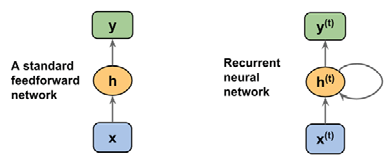

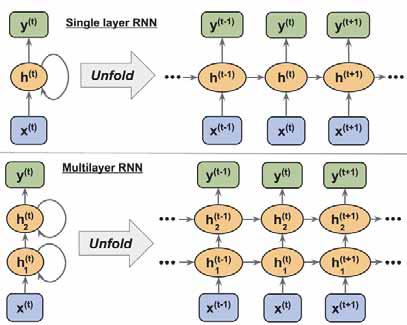

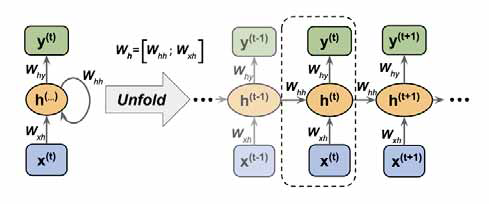

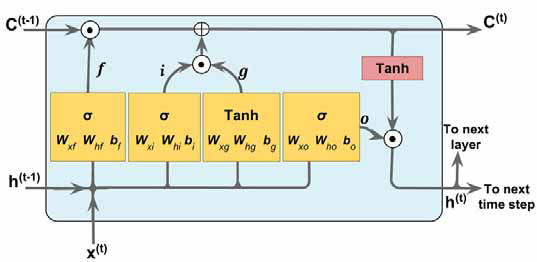

Implementing a multilayer RNN for
sequence modeling in TensorFlow

Now that we introduced the underlying theory behind RNNs, we are ready to move
on to the more practical part to implement RNNs in TensorFlow. During the rest of
this chapter, we will apply RNNs to two common problems tasks:

    1. Sentiment analysis
    2. Language modeling

Project One - performing sentimental
analysis of IMDb movie reviews using
multilayer RNNs

You may recall from Chapter 8, Applying Machine Learning to Sentiment Analysis, that
sentiment analysis is concerned with analyzing the expressed opinion of a sentence
or a text document. In this section and the following subsections, we will implement
a multilayer RNN for sentiment analysis using a many-to-one architecture.
In the next section, we will implement a many-to-many RNN for an application
language modeling. While the chosen examples are purposefully simple to introduce
the main concepts of RNNs, language modeling has a wide range of interesting
applications such as building chatbot — giving computers the ability to directly talk
and interact with a human.

Preparing the data

In the preprocessing steps in Chapter 8, Applying Machine Learning to Sentiment
Analysis, we created a clean dataset named movie_data.csv

In [13]:
import pyprind
import pandas as pd
from string import punctuation
import re
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

In [5]:
df.head(2)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0


0        In 1974, the teenager Martha Moxley (Maggie Gr...
1        OK... so... I really like Kris Kristofferson a...
2        ***SPOILER*** Do not read this, if you think a...
3        hi for all the people who have seen this wonde...
4        I recently bought the DVD, forgetting just how...
                               ...                        
49995    OK, lets start with the best. the building. al...
49996    The British 'heritage film' industry is out of...
49997    I don't even know where to begin on this one. ...
49998    Richard Tyler is a little boy who is scared of...
49999    I waited long to watch this movie. Also becaus...
Name: review, Length: 50000, dtype: object

###### Preprocessing the data:
###### Separate words and
###### count each word's occurrence

In [7]:
from collections import  Counter

counter = Counter()
pbar = pyprind.ProgBar(len(df['review']), title='Counter words occurrences')

for i, review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' for c in review]).lower()
    df.loc[i, 'review'] = text
    pbar.update()
    counter.update(text.split())


# Create a mapping
# Map each unique word to an integer

word_counters = sorted(counter, key=counter.get, reverse=True)
print(word_counters[:5])

word_to_unit = {word: ii for ii, word in enumerate(word_counters, 1)}

mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), title='Map reviews to ints')

for review in df['review']:
    mapped_reviews.append([word_to_unit[word] for word in review.split()])
    pbar.update()

Counter words occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:06
Map reviews to ints


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


there is one issue that we still need to solve—the sequences currently have
different lengths. In order to generate input data that is compatible with our RNN
architecture, we will need to make sure that all the sequences have the same length

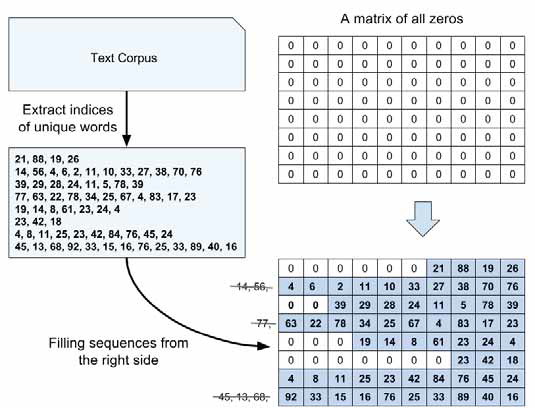

Note that sequence_length is, in fact, a hyperparameter and can be tuned
for optimal performance. Due to page limitations, we did not optimize this
hyperparameter further, but we encourage you to try this with different values for
sequence_length, such as 50, 100, 200, 250, and 300.

Check out the following code for the implementation of these steps to create
sequences of the same length:

In [10]:
## Define same-length sequences
## if sequence length < 200: left-pad with zeros
## if sequence length > 200: use the last 200 elements

sequence_length = 200

sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=np.int32)

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(review_arr):] = review_arr[-sequence_length:]

After we preprocess the dataset, we can proceed with splitting the data into separate training_set test_set

In [11]:
X_train = sequences[:25000,:]
y_train = df.loc[:25000, 'sentiment'].values
X_test = sequences[:25000:,:]
y_test = df.loc[25000:, 'sentiment'].values

In [12]:
np.random.seed(123)

## Define a function to generate mini-batchs

def create_batch_generator(x, y=None, batch_size=64):
    n_batchs = len(x) //batch_size
    x = x[:n_batchs*batch_size]
    if y is not None:
        y = y[:n_batchs*batch_size]
    for ii in range(0, len(x), batch_size):
        if y is not None:
            yield x[ii:ii+batch_size], y[ii:ii+batch_size]
        else:
            yield x[ii:ii+batch_size]

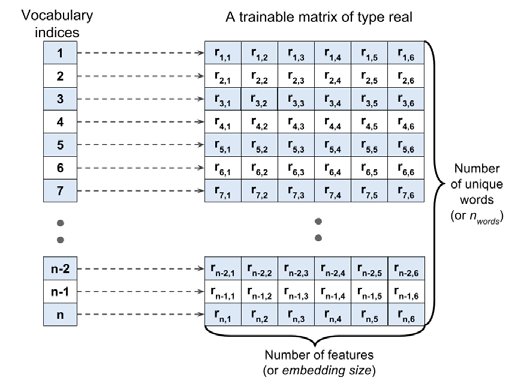

􀀷􀁈􀁑􀁖􀁒􀁕􀀩􀁏􀁒􀁚􀀃􀁌􀁐􀁓􀁏􀁈􀁐􀁈􀁑􀁗􀁖􀀃􀁄􀁑􀀃􀁈􀁉􀃀􀁆􀁌􀁈􀁑􀁗􀀃􀁉􀁘􀁑􀁆􀁗􀁌􀁒􀁑􀀏􀀃tf.nn.embedding_lookup, that maps
each integer that corresponds to a unique word, to a row of this trainable matrix. For
􀁈􀁛􀁄􀁐􀁓􀁏􀁈􀀏􀀃􀁌􀁑􀁗􀁈􀁊􀁈􀁕􀀃􀀔􀀃􀁌􀁖􀀃􀁐􀁄􀁓􀁓􀁈􀁇􀀃􀁗􀁒􀀃􀁗􀁋􀁈􀀃􀃀􀁕􀁖􀁗􀀃􀁕􀁒􀁚􀀏􀀃􀁌􀁑􀁗􀁈􀁊􀁈􀁕􀀃􀀕􀀃􀁌􀁖􀀃􀁐􀁄􀁓􀁓􀁈􀁇􀀃􀁗􀁒􀀃􀁗􀁋􀁈􀀃􀁖􀁈􀁆􀁒􀁑􀁇􀀃􀁕􀁒􀁚􀀏􀀃
and so on. Then, given a sequence of integers, such as 􀀟􀀓􀀏􀀃􀀘􀀏􀀃􀀖􀀏􀀃􀀗􀀏􀀃􀀔􀀜􀀏􀀃􀀕􀂫􀀡, we need to
look up the corresponding rows for each element of this sequence.

Building an RNN model